# Applied Parallel Programming
## Project: Parallelize K-means


## Thông tin thành viên
| Họ tên | MSSV | Task | Đóng góp |
|----------------------|------------|-----------------|---|
| Nguyễn Ngọc Phước    | 19127519   | - cài đặt kmeans tuần tự<br>  - song song hóa tính distance<br> - share memory distance<br> - kmeans version 1 và 2   |36%|
| Phan Vĩ Giai         | 19127639   | - cài đặt fill missing value tuần tự, song song CPU, GPU<br> - cài đặt Standardization tuần tự, song song CPU, GPU<br> - EDA<br> - Đánh giá kết quả các phương pháp preprocess  |32%|
| Võ Nhất Huy          | 19127642   | - song song hóa nearest centroid<br> - Sklearn Kmeans<br> - song song hóa fill missing value<br> - Tối ưu và cải thiện Kmeans trên GPU<br> - Đánh giá kết quả các bước trong Kmeans<br> - Lên plan và hoàn thiện đồ án   |32%|



**Dataset:** https://www.kaggle.com/code/des137/customer-segmentation-credit-cards/input

**Github:** https://github.com/molr298/APP_Credit_Segmentation

## Introduction

K-means là một thuật toán học không giám sát. Với dataset mà các điểm dữ liệu không được gán nhãn, việc của chúng ta là đi gom nhóm các điểm dữ liệu đó lại sao cho dữ liệu trong 1 cụm tương đồng với nhau

<div>
<img src="https://preview.redd.it/wodjl2e8ffw71.png?width=1121&format=png&auto=webp&s=1a723f05e981efee1519c4999c95c6611c587c0f" width="500"/>
</div>

Ý tưởng đơn giản nhất về cluster (cụm) là tập hợp các điểm ở gần nhau trong một không gian nào đó

Về lí thuyết, các bước thực hiện K-means đơn giản như sau:
- Khởi tạo: chọn ngẫu nhiên k điểm bất kì làm tâm

- Nhóm dữ liệu: Với mỗi điểm dữ liệu trên dataset, nhóm chúng với tâm gần nhất

*   List item
*   List item



$ \mathbb{S}_i^t=\left\{ x_p : |x_p - m_i^t |^2 \le |x_p-m_j^t|^2 \right\}, \vee j, 1 \le j \le k $

- Cập nhật tâm cụm (centroids) : Với mỗi cụm sau khi nhóm lại, ta cập nhập lại điểm trung tâm của chúng bằng cách lấy trung bình cộng
- Lặp lại bước gom cụm cho tới khi kết quả sau khi gom nhóm không có sự khác biệt

$ m_{i}^{(t+1)}=\frac{1}{|\mathbb{S}_{i}^{t}|}\sum_{x_{j}\in \mathbb{S}_i^t}^{}x_j $

#### Ứng dụng K-means trong bài toán Credit Card

Đối với ngân hàng, không phải tất cả khách hàng đều giống nhau. Hành vi tiêu dùng của khách hàng được thể hiện rất khác nhau, dựa trên nhiều yếu tố như thu nhập, chi tiêu, hạn mức tín dụng,...

Với số lượng khách hàng ngày càng tăng và nhu cầu được cá nhân hóa trong quá trình sử dụng dịch vụ, cần có một phương pháp để nhóm các khách hàng lại với nhau.

Mục đích của việc phân tích và gom nhóm này là nhóm chủ thẻ tín dụng vào các nhóm thích hợp để hiểu rõ hơn về nhu cầu và hành vi của họ và để phục vụ họ tốt hơn với các ưu đãi và cách phục vụ phù hợp.

## Import Libary

In [1]:
import math

import pandas as pd
import numpy as np
from numba import cuda, void, float64, int32, jit, njit, prange
import numba as nb
import time
import copy
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

## Read Data

In [2]:
df_data = pd.read_csv('data/CC GENERAL.csv')
df_data = df_data.drop('CUST_ID', axis=1)

In [ ]:
def highlight_minimum_time(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

## EDA

### Data description

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [ ]:
df_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Preprocessing

### Fill missing value

Fill missing value với 3 cách tiếp cận:
- Phương pháp 1: Xây dựng thuật toán fill missing value và thực thi trên CPU
- Phương pháp 2: Xây dựng thuật toán fill missing value và thực thi trên CPU với thư viện numba
- Phương pháp 3: Sử dụng thư viện hàm có sẵn numpy

#### Fill missing CPU

**Phương pháp 1: Xây dựng thuật toán fill missing value và thực thi trên CPU**

Missing value được điền bằng phương pháp sau:
- Tìm trung bình (không tính null) trên cột
- Với cell của mỗi dòng, điền chính giá trị trung bình của cột được tính bên trên

In [ ]:
@njit(parallel=False)
def fill_missing_org(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in range(n):
        data_i = df[:, i]
        res[:, i] = data_i.copy()
        mean_data_i = np.nanmean(data_i)

        inds = np.where(np.isnan(data_i))
        res[inds[0], i] = mean_data_i

    return res

#### Fill missing CPU Parallel

**Phương pháp 2: Xây dựng thuật toán fill missing value và thực thi trên CPU với thư viện numba**

Missing value được điền bằng phương pháp sau:
- Tìm trung bình (không tính null) trên cột
- Với cell của mỗi dòng, điền chính giá trị trung bình của cột được tính bên trên

Phương pháp này được cài đặt với sự hỗ trợ của thư viện numba. Ở đây, sử dụng hàm prange, mục đích để song song hoá công việc fill missing value (Điền giá trị trung bình của cell của mỗi dòng) với thuật toán được đề cập bên trên.

In [ ]:
@jit(nopython=True, parallel=True)
def fill_missing_parallel(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in prange(n):
        data_i = df[:, i]
        res[:, i] = data_i.copy()
        mean_data_i = np.nanmean(data_i)

        inds = np.where(np.isnan(data_i))
        res[inds[0], i] = mean_data_i

    return res

#### Expected result using Numpy

**Phương pháp 3: Sử dụng thư viện hàm có sẵn numpy**

Numpy cung cấp cho ta thư viện hàm có sẵn để làm các công việc về preprocessing dữ liệu cũng như tối ưu tốc độ tính toán dữ liệu so với phương pháp cài đặt truyền thống.

Phương pháp được triển khai như sau:
- Tìm giá trị trung bình của các cột, kết quả sẽ là ma trận n (số lượng cột của tập dữ liệu) giá trị trung bình
- Tìm index cho các gía trị bị thiếu trên tập dữ liệu
- Fill missing value với ma trận n các giá trị trung bình đã tìm

In [ ]:
df_data_np = df_data.to_numpy()
df_np_exp = df_data_np.copy()

#Obtain mean of columns as you need, nanmean is convenient.
col_mean = np.nanmean(df_np_exp, axis=0)
print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(df_np_exp))

#Place column means in the indices. Align the arrays using take
df_np_exp[inds] = np.take(col_mean, inds[1])

[1.56447483e+03 8.77270726e-01 1.00320483e+03 5.92437371e+02
 4.11067645e+02 9.78871112e+02 4.90350548e-01 2.02457684e-01
 3.64437342e-01 1.35144200e-01 3.24882682e+00 1.47098324e+01
 4.49444945e+03 1.73314385e+03 8.64206542e+02 1.53714648e-01
 1.15173184e+01]


#### Output result running by CPU

In [ ]:
output_fill_missing_org = fill_missing_org(df_data_np)

#### Comparasion diff

In [ ]:
output_fill_missing_org - df_np_exp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Output result running by CPU Parallel

In [ ]:
output_fill_missing_parallel = fill_missing_parallel(df_data_np)

#### Comparasion diff

In [ ]:
output_fill_missing_parallel - df_np_exp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Việc so sánh để xem xét phương pháp cài đặt của ta có chính xác không.

Và kết quả cho thấy ma trận hiệu của kết quả khi dùng thư viện numpy so với phương pháp còn lại cho giá trị là 0

### Measure running time with different strategies

#### Measure time with running with increasing number of columns

Chiến lược đánh giá performance của 3 phương pháp là tăng số lượng cột của tập dữ liệu gốc và so sánh thời gian xử lý của các phương pháp

In [ ]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)
    data_clone = data.copy()

    o_1 = %timeit -o -q col_mean = np.nanmean(data, axis=0); inds = np.where(np.isnan(data)); data_clone[inds] = np.take(col_mean, inds[1])
    o_2 = %timeit -o -q fill_missing_org(data)
    o_3 = %timeit -o -q fill_missing_parallel(data)

    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (8950, 85)
3 of 8 complete (8950, 153)
4 of 8 complete (8950, 221)
5 of 8 complete (8950, 289)
6 of 8 complete (8950, 357)
7 of 8 complete (8950, 425)
8 of 8 complete (8950, 493)


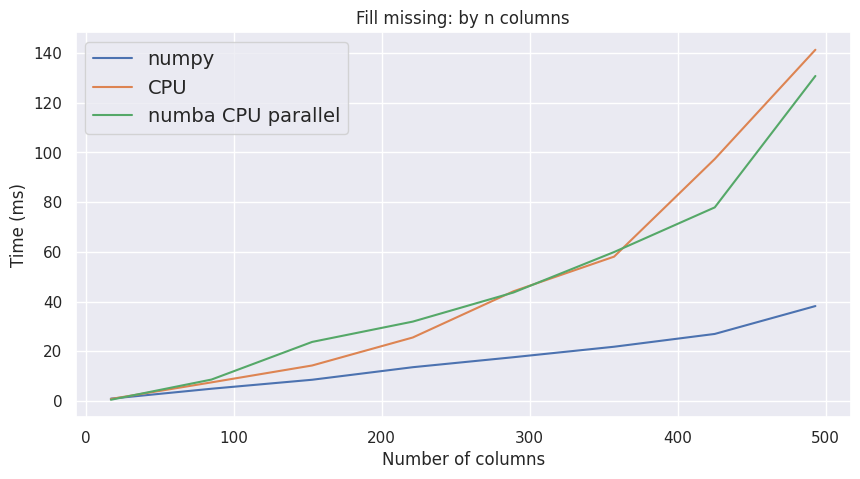

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'numpy', 'CPU', 'numba CPU parallel'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Fill missing: by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp Fill Missing value bao gồm:
    - Phương pháp sử dụng hàm của numpy
    - Phương pháp tự cài đặt Fill Missing Value truyền thống chạy tuần tự trên CPU
    - Phương pháp tự cài đặt Fill Missing Value truyền thống chạy song song trên CPU
- Chiến lược đánh giá performance khi cho tăng số lượng dòng so với dataset gốc:
    - Khi tập dữ liệu có số cột được tăng lên (Dữ liệu được scale theo chiều ngang) thì numpy cho thấy performance tốt nhất so với 2 phương pháp còn lại
    - Phương pháp Fill Missing Value truyền thống chạy tuần tự trên CPU và chạy song song trên CPU có performance gần như bằng nhau và thời gian xử lý sẽ càng tăng khi khối lượng dữ liệu cang tăng (Dữ liệu tăng số cột)

#### Table measuring strategies check time

In [ ]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,numpy,CPU,numba CPU parallel
num_cols,,,
17,0.952802,0.832121,0.511903
85,4.944332,7.506892,8.637241
153,8.557440,14.297441,23.777755
221,13.605590,25.559963,31.952756
289,17.624962,44.139174,43.655969
357,21.841415,58.087651,59.940069
425,26.989678,97.365556,77.899651
493,38.206162,141.317427,130.765543


#### Measure time with running with increasing number of row

In [ ]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    data_clone = data.copy()

    o_1 = %timeit -o -q col_mean = np.nanmean(data, axis=0); inds = np.where(np.isnan(data)); data_clone[inds] = np.take(col_mean, inds[1])
    o_2 = %timeit -o -q fill_missing_org(data)
    o_3 = %timeit -o -q fill_missing_parallel(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (44750, 17)
3 of 8 complete (80550, 17)
4 of 8 complete (116350, 17)
5 of 8 complete (152150, 17)
6 of 8 complete (187950, 17)
7 of 8 complete (223750, 17)
8 of 8 complete (259550, 17)


In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'numpy', 'CPU', 'numba CPU parallel'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)

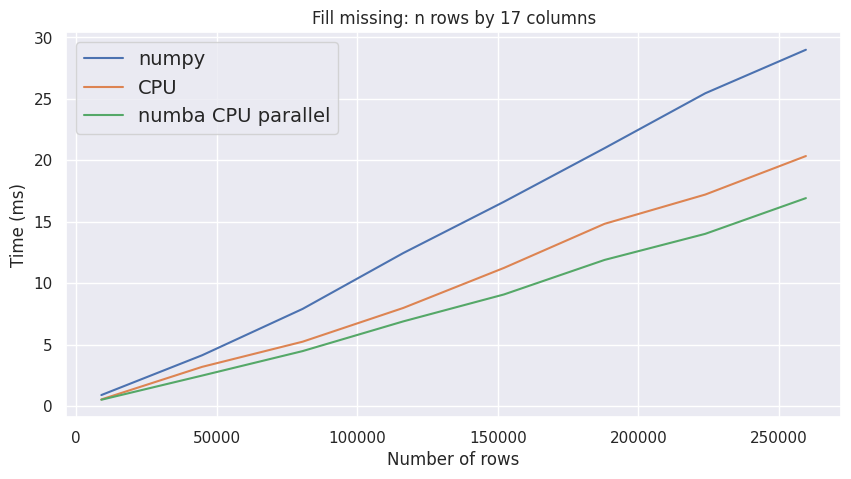

In [ ]:
ax = df_viz.plot()
ax.set_title('Fill missing: n rows by 17 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp Fill Missing value bao gồm:
    - Phương pháp sử dụng hàm của numpy
    - Phương pháp tự cài đặt Fill Missing Value truyền thống chạy tuần tự trên CPU
    - Phương pháp tự cài đặt Fill Missing Value truyền thống chạy song song trên CPU
- Chiến lược đánh giá performance khi cho tăng số lượng dòng so với dataset gốc:
    - Với chiến lược đánh giá performance tăng số dòng dữ liệu (Scale dữ liệu theo chiều dọc) thì kết quả lại đôi lập so với chiến lược đánh giá bên trên (Chiến lược đánh giá bằng cách tăng số cột của tập dữ liệu).
    - Numpy cho thấy kết quả tệ nhất khi so sánh với 2 phương pháp còn lại. Thời gian xử lý của numpy khi số dòng dữ liệu càng tăng tỉ lệ thuận.
    - Phương pháp Fill Missing Value chạy song song trên CPU có performance tốt nhất khi khối lượng dữ liệu càng lớn.

#### Table measuring strategies check time

In [ ]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,numpy,CPU,numba CPU parallel
num_rows,,,
8950,0.884307,0.528277,0.501968
44750,4.119669,3.177430,2.467851
80550,7.899952,5.229094,4.464204
116350,12.446555,7.976435,6.882639
152150,16.620290,11.235454,9.074568
187950,20.986614,14.826032,11.886904
223750,25.453071,17.208268,14.009367
259550,28.997508,20.343521,16.917908


### Standardization

Standardization với 3 cách tiếp cận:
- Phương pháp 1: Xây dựng thuật toán Standardization và thực thi trên CPU
- Phương pháp 2: Xây dựng thuật toán Standardization và thực thi trên CPU với thư viện numba
- Phương pháp 3: Sử dụng thư viện hàm có sẵn Sklearn

#### Standard CPU

**Phương pháp 1: Xây dựng thuật toán Standardization và thực thi trên CPU**

Phương pháp triển khai:
- Tìm giá trị chuẩn hoá của mỗi cell (của mỗi dòng) với công thức tính Z-Score: Giá trị cell - trung bình của cột và cuối cùng chia cho độ lệch chuẩn

<img src="https://media.licdn.com/dms/image/D4D12AQEdjP2al503jA/article-inline_image-shrink_400_744/0/1669192244240?e=1694044800&v=beta&t=QMNj8CNODisZ6PHILLTB-YgX3IbdTsnifS0TmA1_fKM">

- Với mỗi cell, thay thế giá trị bằng giá trị chuẩn hoá đã tính toán

In [ ]:
@njit(parallel=False)
def standard_org(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in range(n):
        data_i = df[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

#### Standard CPU Parallel

**Phương pháp 2: Xây dựng thuật toán Standardization và thực thi trên CPU với thư viện numba**

Phương pháp Chuẩn hoá dữ liệu và thực thi trên CPU với sự hỗ trợ của numba. Sử dụng hàm **prange** để xây dựng chiến lược thực thi tính toán song song các cột dữ liệu đồng thời (Phương pháp tương tự như cách tuần tự trên CPU)

In [ ]:
@jit(nopython=True, parallel=True)
def standard_parallel(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in prange(n):
        data_i = df[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

#### Expected result using Sklearn

In [ ]:
sklearn_std_expected = StandardScaler().fit_transform(df_data_np)

#### Output result running by CPU

In [ ]:
output_std_org = standard_org(df_data_np)

#### Comparasion diff

In [ ]:
output_std_org - sklearn_std_expected

array([[-1.66533454e-15, -4.17166302e-14, -1.08246745e-14, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       [-1.33226763e-15, -2.29816166e-14, -1.18238752e-14, ...,
                    nan, -4.63518113e-15, -6.66133815e-16],
       [-1.44328993e-15, -4.21884749e-15, -3.89965837e-15, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       ...,
       [-1.77635684e-15, -3.86080057e-14, -1.03250741e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -3.86080057e-14, -1.18238752e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -7.30526750e-14, -6.17561557e-16, ...,
                    nan, -1.66533454e-15,  7.99360578e-15]])

#### Output result running by CPU Parallel

In [ ]:
output_std_parallel = standard_parallel(df_data_np)

#### Comparasion diff

In [ ]:
output_std_parallel - sklearn_std_expected

array([[-1.66533454e-15, -4.17166302e-14, -1.08246745e-14, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       [-1.33226763e-15, -2.29816166e-14, -1.18238752e-14, ...,
                    nan, -4.63518113e-15, -6.66133815e-16],
       [-1.44328993e-15, -4.21884749e-15, -3.89965837e-15, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       ...,
       [-1.77635684e-15, -3.86080057e-14, -1.03250741e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -3.86080057e-14, -1.18238752e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -7.30526750e-14, -6.17561557e-16, ...,
                    nan, -1.66533454e-15,  7.99360578e-15]])

### Measure running time with different strategies

#### Measure time with running with increasing number of columns

In [ ]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)

    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_org(data)
    o_3 = %timeit -o -q standard_parallel(data)

    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (8950, 85)
3 of 8 complete (8950, 153)
4 of 8 complete (8950, 221)
5 of 8 complete (8950, 289)
6 of 8 complete (8950, 357)
7 of 8 complete (8950, 425)
8 of 8 complete (8950, 493)


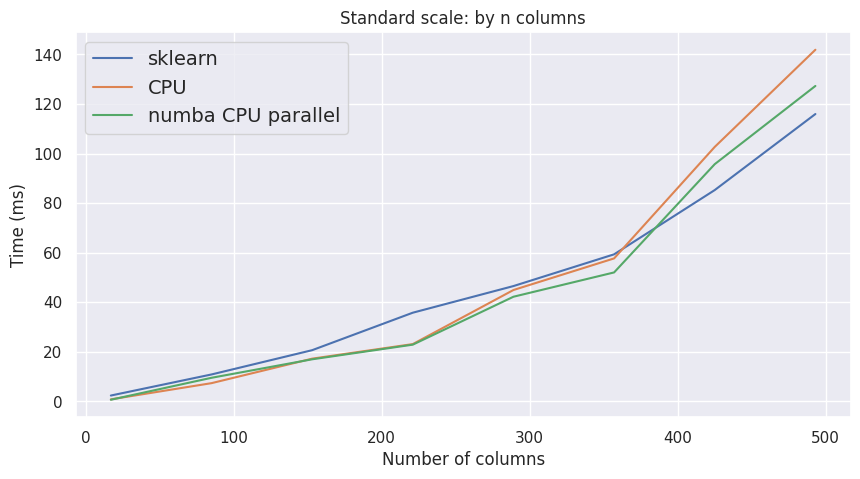

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'sklearn', 'CPU', 'numba CPU parallel'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Standard scale: by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp Standardization bao gồm:
    - Phương pháp sử dụng hàm của Sklearn
    - Phương pháp tự cài đặt Standardization truyền thống chạy tuần tự trên CPU
    - Phương pháp tự cài đặt Standardization truyền thống chạy song song trên CPU
- Chiến lược đánh giá performance khi cho tăng số lượng cột so với dataset gốc:
    - Performance của 3 phương pháp gần như có kết quả như nhau khi xử lý tập dữ liệu khoảng từ 400 cột dữ liệu đổ lại và có kết quả khác biệt khi số lượng cột nhiều hơn 400
    - Khi đó Sklearn lại cho thấy khả năng tính toán mạnh mẽ nhất so với 2 phương pháp còn lại

#### Table measuring strategies check time

In [ ]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,sklearn,CPU,numba CPU parallel
num_cols,,,
17,2.379525,0.842371,0.680417
85,10.885694,7.375870,9.539011
153,20.682049,17.259662,17.000312
221,35.807388,23.143209,22.912943
289,46.553705,44.961536,42.248737
357,59.359343,57.712862,52.056711
425,85.295554,102.711231,95.747761
493,115.975417,141.910963,127.302549


#### Measure time with running with increasing number of row

In [ ]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_org(data)
    o_3 = %timeit -o -q standard_parallel(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (44750, 17)
3 of 8 complete (80550, 17)
4 of 8 complete (116350, 17)
5 of 8 complete (152150, 17)
6 of 8 complete (187950, 17)
7 of 8 complete (223750, 17)
8 of 8 complete (259550, 17)


In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'sklearn', 'CPU', 'numba CPU parallel'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)

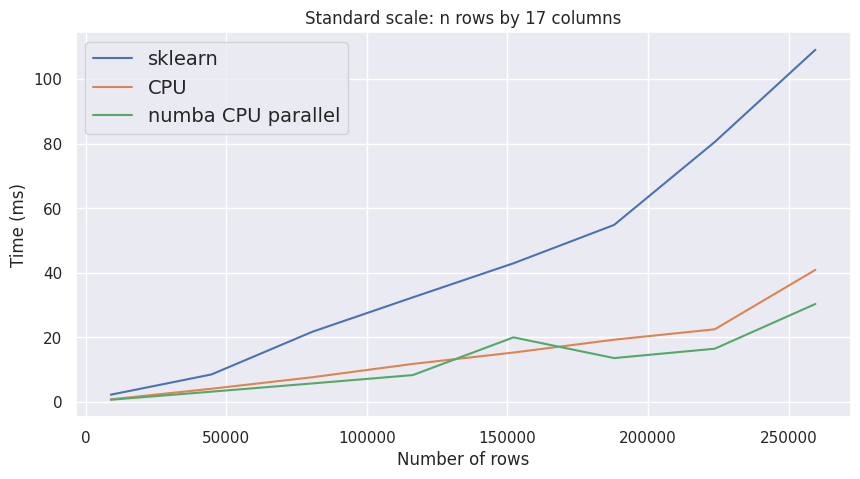

In [ ]:
ax = df_viz.plot()
ax.set_title('Standard scale: n rows by 17 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp Standardization bao gồm:
    - Phương pháp sử dụng hàm của Sklearn
    - Phương pháp tự cài đặt Standardization truyền thống chạy tuần tự trên CPU
    - Phương pháp tự cài đặt Standardization truyền thống chạy song song trên CPU
- Chiến lược đánh giá performance khi cho tăng số lượng dòng so với dataset gốc:
    - Performance của Sklearn gần như tỉ lệ thuận so với khối lượng dữ liệu => Dữ liệu được tăng số lượng dòng đồng nghĩa thời gian xử lý phải càng lớn
    - Đứng đầu là phương pháp Standardization song song trên CPU => Dựa vào biểu đồ trên thì ta có thể dự đoán khi càng số dòng dữ liệu thì thời gian xử lý cũng tăng nhưng vẫn thấp nhất so với 2 phương pháp còn lại
    - Và đứng thứ nhì là phương pháp Standardization chạy tuần tự trên CPU

#### Table measuring strategies check time

In [ ]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,sklearn,CPU,numba CPU parallel
num_rows,,,
8950,2.256922,0.817649,0.688898
44750,8.534094,4.101653,3.197107
80550,21.738993,7.659454,5.742887
116350,32.426274,11.797515,8.331905
152150,42.987072,15.319686,20.027192
187950,54.879502,19.305212,13.605697
223750,80.594167,22.531595,16.508927
259550,109.186064,40.952108,30.377022


### GPU

Sau khi đã implement và thực hiện các phép so sánh trên CPU, ta sẽ tiến hành thực hiện fill missing value và chuẩn hóa dữ liệu bằng CUDA

#### Fill missing value

Với fill missing value trên CUDA, ở đây ta thực hiện tìm ra mean value cho từng column và gán nó vào 1 mảng 1 chiều.

Trên mỗi block, các thread sẽ handle từng phần tử trong một mảng (cột). Nếu như phần tử đó null thì sẽ được fill bằng value tương ứng với cột đó

In [ ]:
@cuda.jit
def fill_missing_kernel(data, fill_value):
    r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if r < data.shape[0] and c < data.shape[1]:
      if math.isnan(data[r, c]):
            data[r, c] = fill_value[c]

def next_power_of_2(x):
    return 1 << (x - 1).bit_length()

def fill_missing_parallel_gpu(arr):
    filled_arr = copy.deepcopy(arr)
    mean_arr = np.nanmean(filled_arr, axis=0)
    mean_device = cuda.to_device(mean_arr)
    arr_device = cuda.to_device(filled_arr)

    real_dim_x = filled_arr.shape[1]
    dim_x = next_power_of_2(real_dim_x)
    dim_y = dim_x
    block_size = (dim_x,dim_x)
    blocks_per_grid_x = math.ceil(filled_arr.shape[1] / block_size[0])
    blocks_per_grid_y = math.ceil(filled_arr.shape[0] / block_size[1])
    grid_size = (blocks_per_grid_x, blocks_per_grid_y)

    fill_missing_kernel[grid_size, block_size](arr_device, mean_device)
    filled_arr = arr_device.copy_to_host()
    return filled_arr

In [ ]:
np.isnan(df_data_np).any()

True

In [ ]:
df_fill_missing = fill_missing_parallel_gpu(df_data_np)
np.isnan(df_fill_missing).any()

False

In [ ]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)

    o_1 = %timeit -o -q fill_missing_org(data)
    o_2 = %timeit -o -q fill_missing_parallel(data)
    o_3 = %timeit -o -q fill_missing_parallel_gpu(data)


    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (8950, 85)
3 of 8 complete (8950, 153)
4 of 8 complete (8950, 221)
5 of 8 complete (8950, 289)
6 of 8 complete (8950, 357)
7 of 8 complete (8950, 425)
8 of 8 complete (8950, 493)


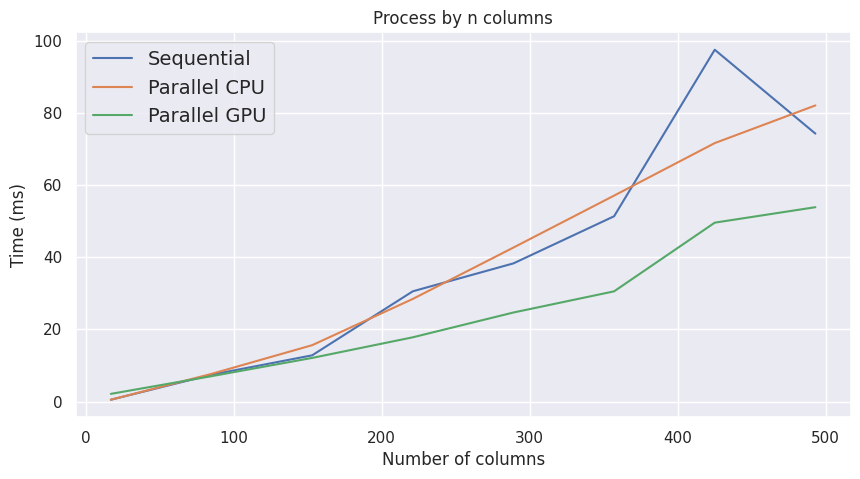

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'Sequential', 'Parallel CPU', 'Parallel GPU'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Process by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp chuẩn hóa dữ liệu bao gồm:
    - Sử dụng numpy fill missing value bằng numpy.where
    - Sử dụng numpy fill missing value kết hợp với numba song song trên CPU
    - Phương pháp tự cài đặt fill missing value trên GPU
- Chiến lược đánh giá performance khi cho tăng số lượng cột so với dataset gốc:
    - Performance của việc thực thi song song trên CPU và không song song không có quá nhiều sự khác biệt. Chỉ có ở một vài điểm thời gian của việc xử lí không song song có sự tăng đột biến => thiếu ổn định.
    - Kết quả từ GPU cho ra là khả quan nhất khi mà tốc độ luôn thấp nhất khi so với 2 phương pháp còn lại

In [ ]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    o_1 = %timeit -o -q fill_missing_org(data)
    o_2 = %timeit -o -q fill_missing_parallel(data)
    o_3 = %timeit -o -q fill_missing_parallel_gpu(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (44750, 17)
3 of 8 complete (80550, 17)
4 of 8 complete (116350, 17)
5 of 8 complete (152150, 17)
6 of 8 complete (187950, 17)
7 of 8 complete (223750, 17)
8 of 8 complete (259550, 17)


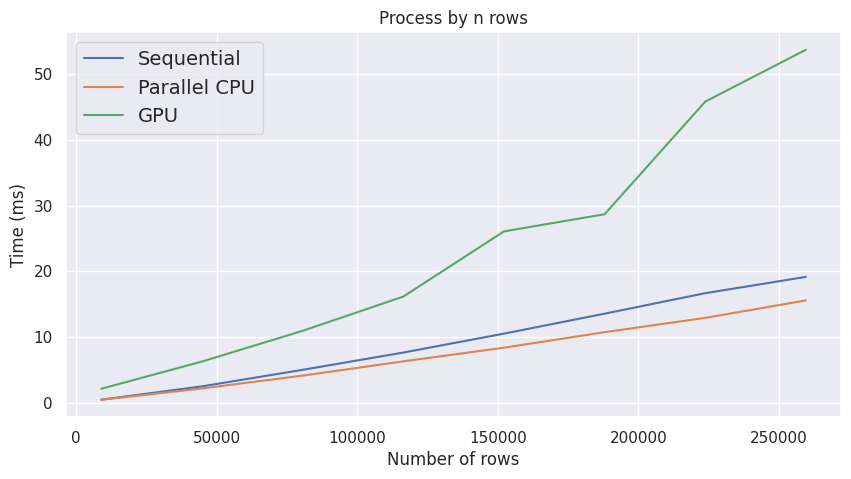

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'Sequential', 'Parallel CPU', 'GPU'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Process by n rows')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp chuẩn hóa dữ liệu bao gồm:
    - Sử dụng numpy fill missing value bằng numpy.where
    - Sử dụng numpy fill missing value kết hợp với numba song song trên CPU
    - Phương pháp tự cài đặt fill missing value trên GPU
- Chiến lược đánh giá performance khi cho tăng số lượng dòng so với dataset gốc:
    - Trái ngược lại với kết quả ở trên, thực thi bằng GPU với fill missing value cho ra kết quả chậm nhất
    - Việc thực thi trên CPU song song lúc này cho ra kết quả nhanh nhất trong 3 phương pháp

#### Standardization

In [ ]:
import numpy as np
import math
import numba.cuda as cuda

@cuda.jit
def standard_gpu(df, result):
    i, j = cuda.grid(2)
    if i < df.shape[0] and j < df.shape[1]:
        data_ij = df[i, j]
        mean_data_j = 0.0
        std_data_j = 0.0
        count = 0

        for k in range(df.shape[0]):
            data_kj = df[k, j]
            if not (data_kj != data_kj):  # Check for NaN
                mean_data_j += data_kj
                std_data_j += data_kj ** 2
                count += 1

        if count > 0:
            mean_data_j /= count
            std_data_j = math.sqrt((std_data_j / count) - (mean_data_j ** 2))

            if not (data_ij != data_ij):  # Check for NaN
                result[i, j] = (data_ij - mean_data_j) / std_data_j

def standard_parallel_gpu(df):
    n_rows, n_cols = df.shape
    threads_per_block = (16, 16)
    blocks_per_grid_x = (n_rows + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (n_cols + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    d_df = cuda.to_device(df)
    d_result = cuda.device_array_like(d_df)

    standard_gpu[blocks_per_grid, threads_per_block](d_df, d_result)

    result = d_result.copy_to_host()
    return result


In [ ]:
df_data_np = df_data.to_numpy()

In [ ]:
standard_parallel_gpu(df_data_np)

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.30548157,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08773463,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.09986968,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.32954733,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34078648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.3270727 ,
        -0.52555097, -4.12276757]])

In [ ]:
fill_missing_parallel_gpu(df_data_np)

array([[4.09007490e+01, 8.18182000e-01, 9.54000000e+01, ...,
        1.39509787e+02, 0.00000000e+00, 1.20000000e+01],
       [3.20246742e+03, 9.09091000e-01, 0.00000000e+00, ...,
        1.07234022e+03, 2.22222000e-01, 1.20000000e+01],
       [2.49514886e+03, 1.00000000e+00, 7.73170000e+02, ...,
        6.27284787e+02, 0.00000000e+00, 1.20000000e+01],
       ...,
       [2.33986730e+01, 8.33333000e-01, 1.44400000e+02, ...,
        8.24183690e+01, 2.50000000e-01, 6.00000000e+00],
       [1.34575640e+01, 8.33333000e-01, 0.00000000e+00, ...,
        5.57556280e+01, 2.50000000e-01, 6.00000000e+00],
       [3.72708075e+02, 6.66667000e-01, 1.09325000e+03, ...,
        8.82889560e+01, 0.00000000e+00, 6.00000000e+00]])

### Measure running time with different strategies

#### Measure time with running with increasing number of columns

In [ ]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)

    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_parallel_gpu(df_data_np)
    o_3 = %timeit -o -q standard_parallel_gpu(df_data_np)

    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (8950, 85)
3 of 8 complete (8950, 153)
4 of 8 complete (8950, 221)
5 of 8 complete (8950, 289)
6 of 8 complete (8950, 357)
7 of 8 complete (8950, 425)
8 of 8 complete (8950, 493)


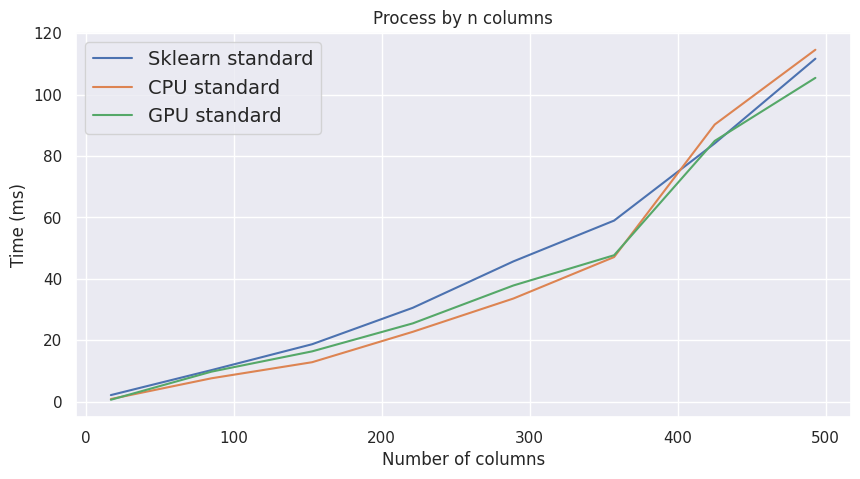

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'Sklearn standard', 'CPU standard', 'GPU standard'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Process by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp chuẩn hóa dữ liệu bao gồm:
    - Phương pháp sử dụng hàm của Sklearn
    - Phương pháp tự cài đặt Standardization chạy song song trên GPU
    - Phương pháp tự cài đặt Standardization truyền thống chạy song song trên CPU
- Chiến lược đánh giá performance khi cho tăng số lượng cột so với dataset gốc:
    - Performance của cả 3 phương pháp không có quá nhiều sự chênh lệch khi scale-up theo số lượng cột
    - Tuy nhiên vẫn có thể thấy được Sklearn có kết quả nhỉnh hơi đôi chút ở phần lớn kích thước của dataset

#### Measure time with running with increasing number of row

In [ ]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard_org(data)
    o_3 = %timeit -o -q standard_parallel(data)

    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (44750, 17)
3 of 8 complete (80550, 17)
4 of 8 complete (116350, 17)
5 of 8 complete (152150, 17)
6 of 8 complete (187950, 17)
7 of 8 complete (223750, 17)
8 of 8 complete (259550, 17)


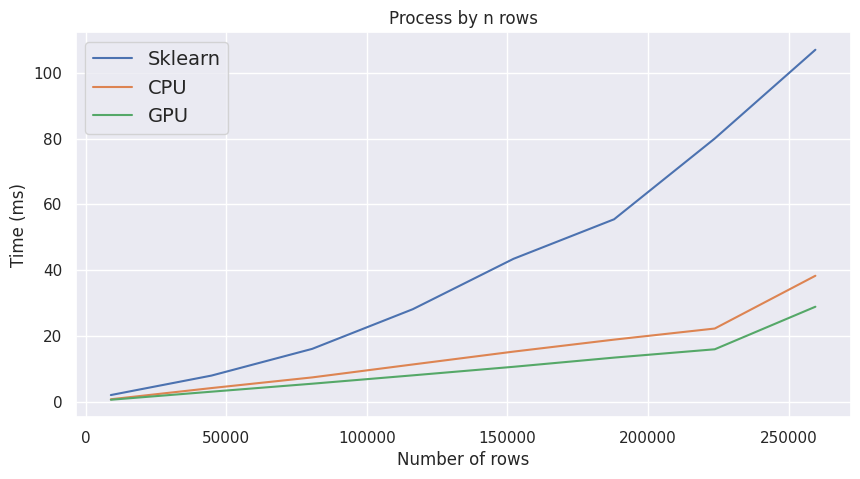

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'Sklearn', 'CPU', 'GPU'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Process by n rows')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

**Nhận xét biểu đồ đánh giá tốc độ tính toán dữ liệu**
- Biểu đồ thể hiện performance của 3 phương pháp Standardization bao gồm:
    - Phương pháp sử dụng hàm của Sklearn
    - Phương pháp tự cài đặt Standardization truyền thống chạy tuần tự trên CPU
    - Phương pháp tự cài đặt Standardization truyền thống chạy song song trên GPU
- Chiến lược đánh giá performance khi cho tăng số lượng dòng so với dataset gốc:
    - Performance của Sklearn gần như tỉ lệ thuận so với khối lượng dữ liệu => Dữ liệu được tăng số lượng dòng đồng nghĩa thời gian xử lý phải càng lớn
    - Đứng đầu là phương pháp Standardization song song trên GPU => Dựa vào biểu đồ trên thì ta có thể dự đoán khi càng tăng số dòng dữ liệu thì thời gian xử lý cũng tăng nhưng vẫn thấp nhất so với 2 phương pháp còn lại.
    - Và đứng thứ nhì là phương pháp Standardization chạy tuần tự trên CPU

### Correlation matrix

- Sau bước Chuẩn hoá dữ liệu và Fill Missing Value, cần lựa chọn tập thuộc tính có độ tương quan để làm nguồn dữ liệu cho thuật toán máy học.
- Ở đây, sử dụng một phương pháp có tên là Correlation Matrix để mô hình hoá độ tương quan của các thuộc tính để giúp ta đánh giá được mức độ và tầm quan trọng của các thuộc tính.
- Từ đó, lên chiến lược phân tích và lựa chọn ra tập thuộc tính có độ tương quan cao và phù hợp cho thuật toán máy học
- Việc đánh gía và gom nhóm các thuộc tính có độ tương quan cao góp phần nâng cao hiệu suất của mô hình máy học, tránh tình trạng mô hình học máy không chính xác học quá khớp với dữ liệu

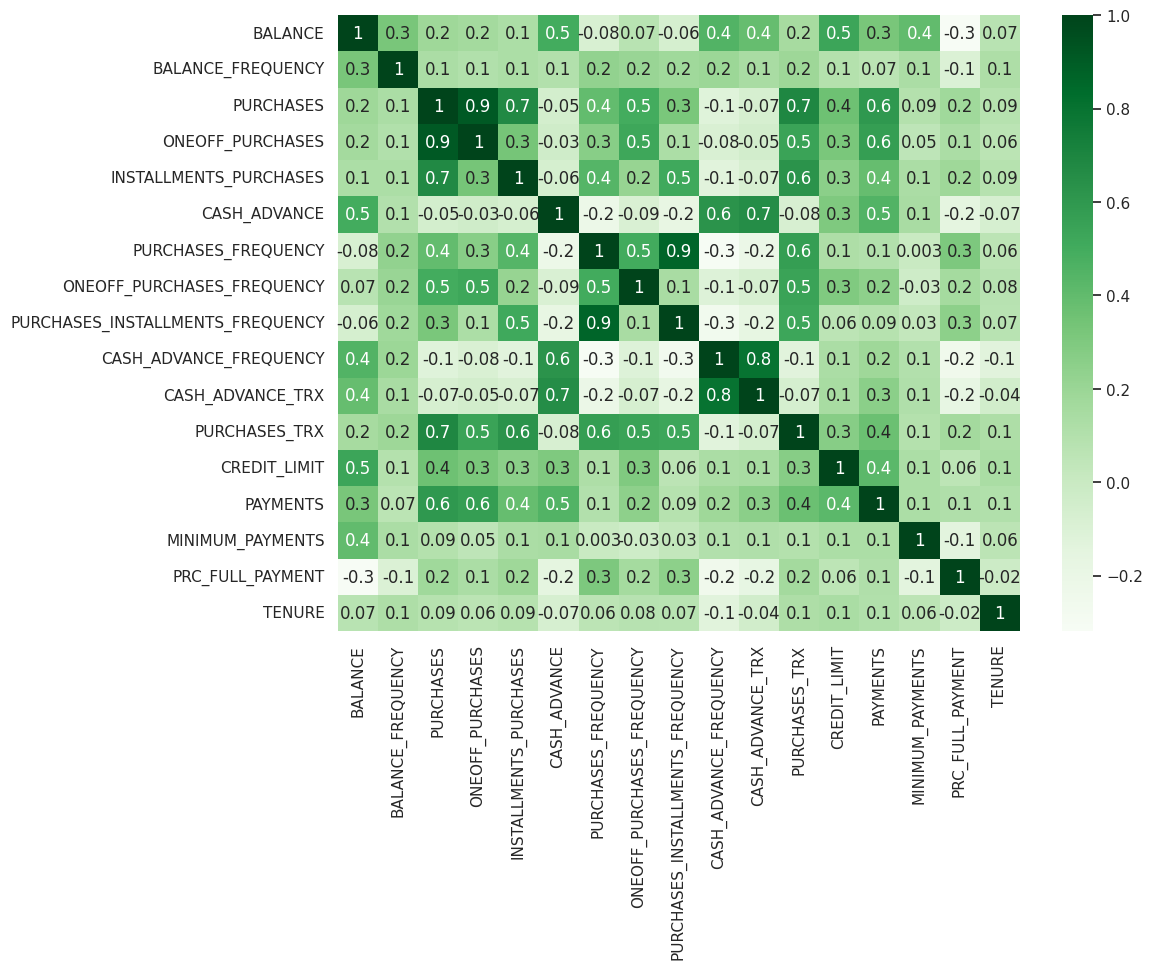

In [ ]:
corr = df_data.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True, fmt='.1g')
plt.show()

### Feature Selection

In [ ]:
features = ['BALANCE', 'CASH_ADVANCE','PURCHASES', 'ONEOFF_PURCHASES', \
            'INSTALLMENTS_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', \
            'PURCHASES_TRX', 'PAYMENTS', 'CASH_ADVANCE_FREQUENCY',
            'CASH_ADVANCE_TRX', 'PURCHASES_FREQUENCY']
df_data = df_data[features]
df_data_np = df_data.to_numpy()
np_data = standard_parallel_gpu(df_data_np)
np_data = fill_missing_parallel_gpu(np_data)

Dựa vào Ma trận tương quan phía trên, ta phân tích và lựa chọn được 11 thuộc tính có độ tương quan cao (Các thuộc tính có điểm đánh giá từ 0.5 trở lên) và phù hợp với mô hình máy học.

## Parallelism Kmeans

### MSE

Khi ta chạy các hàm trên CPU và GPU, ta cần quan tâm không chỉ về tốc độ, mà còn độ chính xác giữa 2 (hoặc nhiều) phiên bản khác nhau này.

Có nhiều lý do khiến cho việc chạy trên CPU có sự sai khác với GPU như: thuật toán sai, tính toán số thực trên GPU khác, làm tròn khác,...

Hàm MSE là hàm để ta quan sát và so sánh kết quả sau quá trình chạy giữa GPU và CPU xem độ lỗi giữa chúng.

In [ ]:
def mse(result_1, result_2):
  return (np.square(result_1 - result_2)).mean()

### Init K & centroid

In [ ]:
k = 20
np.random.seed(0)
centroid = np_data[np.random.randint(np_data.shape[0], size=k), :]

### CPU

Ở đây, ta sẽ lần lượt tính toán khoảng cách của từng data sample đến từng centroid một.
Đầu ra của hàm này là một mảng 2 chiều (n, k). Với n là số lượng data sample và k là số centroid.
Ta sẽ tuần tự lặp qua từng data sample, với mỗi data sample ta lặp qua từng centroid để tính khoảng cách giữa chúng.

In [ ]:
def calc_distance_cpu(data, data_centroid):
    dist = np.zeros((data.shape[0], data_centroid.shape[0]))
    for i in range(data.shape[0]):
        for j in range(data_centroid.shape[0]):
            dist[i][j] = np.linalg.norm(data[i] - data_centroid[j])
    return dist

Khi có được khoảng cách giữa từng data sample và từng centroid, ta cần tiếp tục xét xem: với từng data sample, nó gần centroid nào nhất.

Để thực hiện việc này, ta chỉ cần tìm min của từng hàng trong ma trận khoảng cách trước đó (đầu ra của bước trước).

Có 2 implemment ở đây, phiên bản đầu tiên sẽ dùng numpy, phiên bản sau dùng vòng for để tìm min trên từng data sample.

In [ ]:
def get_nearest_centroid_cpu_ver1(distance):
    return np.argmin(distance, axis=1)

def get_nearest_centroid_cpu_ver2(distance):
    num_samples, num_centroids = distance.shape
    nearest_centroid = np.zeros(num_samples, dtype=np.int32)

    for i in range(num_samples):
        min_dist = distance[i, 0]
        min_idx = 0
        for j in range(1, num_centroids):
            if distance[i, j] < min_dist:
                min_dist = distance[i, j]
                min_idx = j
        nearest_centroid[i] = min_idx

    return nearest_centroid

Sau khi các sample biết clusster mà nó thuộc về, ta có thể tiến hành đi trung bình cộng giữa chúng để cho ra tập centroid mới.

In [ ]:
def get_new_centroids(data, data_nearest_centroid, number_of_centroid):
    result_centroids = np.zeros((number_of_centroid, data.shape[1]))
    for i in range(number_of_centroid):
        result_centroids[i] = data[np.where(data_nearest_centroid == i)].mean(axis=0)
    return result_centroids

In [ ]:
def kmean_cpu(data, initial_centroid):
    centroid_cpu = copy.deepcopy(initial_centroid)
    has_changed_centroid = True
    while has_changed_centroid:
        calculated_dist = calc_distance_cpu(data, centroid_cpu)  # calculated dist
        nearest_centroid = get_nearest_centroid_cpu_ver1(calculated_dist)  # assigned to centroid
        new_centroid = get_new_centroids(data, nearest_centroid, k)
        if np.all(new_centroid == centroid_cpu):
            has_changed_centroid = False
        else:
            centroid_cpu = new_centroid
    return centroid_cpu

### GPU

Block per grid và thread per block là 2 tham số đầu vào quan trọng khi khởi chạy kernel trên GPU.

QUa hàm này, ta sẽ sinh ra số lượng thread (x, y) với y nhiều hơn (hoặc bằng) với số lượng centroids, x bằng với số data sample.

Số lượng thread này sau đó được phân bố đều vào các block tương ứng.
Hiện đang spawn ra block hình vuông với số lượng thread của 1 block là x*y và x==y

In [ ]:
def calc_dimension_for_distance(data, data_centroid):
    def next_power_of_2(x):
      return 1 << (x - 1).bit_length()
    real_dim_x = data_centroid.shape[0]
    dim_x = next_power_of_2(real_dim_x)
    dim_y = dim_x
    thread_per_blocks = (dim_x, dim_y)
    blocks_per_grid_x = 1
    blocks_per_grid_y = math.ceil(data.shape[0] / thread_per_blocks[0])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    return thread_per_blocks, blocks_per_grid

In [ ]:
dist_tpb, dist_bpg = calc_dimension_for_distance(np_data, centroid)
data_shape = (dist_tpb[0],np_data.shape[1])
centroid_shape = (centroid.shape[0], centroid.shape[1])

Mặc định của numba, hàm kernel sẽ được compile về code C ở lần chạy đầu tiên, tuy nhiên việc này sẽ gây ra sai lệch khi benchmark về thời gian chạy.

Bởi ở lần chạy đầu tiên, việc chạy hàm sẽ tính luôn thời gian để compile lần đầu, từ lần 2 trở đi sẽ không xuất hiện khoảng thời gian này, nên sẽ xảy ra sai lệch về thời gian chạy.

Để ngăn chặn, ta có thể ép numba compile ngay khi định nghĩa hàm qua các anotation liên quan để định nghĩa trước kiểu dữ liệu của đầu vào, đầu ra của hàm. Qua đây, việc chạy các hàm kernel về sau sẽ đảm bảo công bằng, không kèm thời gian compile. Đây chính là lợi ích của việc pre-compile.

In [ ]:
@cuda.jit(void(nb.types.Array(dtype=float64, ndim=2, layout="F"), nb.types.Array(dtype=float64, ndim=2, layout="C"), nb.types.Array(dtype=float64, ndim=2, layout="C")))
def calc_distance_kernel_ver1(data, data_centroid, result):
    r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if r < data.shape[0] and c < data_centroid.shape[0]:
        total = 0
        for i in range(data_centroid.shape[1]):
            total += math.pow(data[r][i] - data_centroid[c][i], 2)
        result[r, c] = math.sqrt(total)

def calc_distance_gpu_ver1(data, data_centroid):
    result = np.zeros((data.shape[0], data_centroid.shape[0]))
    # data_device = cuda.to_device(data) # old version
    data_device = data
    centroid_device = cuda.to_device(data_centroid)
    result_device = cuda.to_device(result)

    # invoke kernel
    calc_distance_kernel_ver1[dist_bpg, dist_tpb](data_device, centroid_device, result_device)
    result = result_device.copy_to_host()
    return result

Ở ver 2, việc tận dụng shared memory trên lý thuyết sẽ giúp truy xuất vùng nhớ nhanh hơn. Ở ver1, việc truy xuất global memory nhiều lần trên tất cả các thread sẽ gây chậm trễ vì thời gian đọc lâu.

Việc sử dụng shared memory của từng block sẽ giúp các thread
trong cùng 1 block sử dụng chung vùng như sharememory có thời gian truy xuất thấp hơn global memory.

In [ ]:
@cuda.jit(void(nb.types.Array(dtype=float64, ndim=2, layout="F"), nb.types.Array(dtype=float64, ndim=2, layout="C"), nb.types.Array(dtype=float64, ndim=2, layout="C")))

def calc_distance_kernel_ver2(data, data_centroid, result):
    shared_centroid = cuda.shared.array(shape=centroid_shape, dtype=float64)
    shared_data = cuda.shared.array(shape=data_shape, dtype=float64)

    r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if(cuda.threadIdx.y == 0 and cuda.threadIdx.x < data_centroid.shape[0]):
      for i in range(data_centroid.shape[1]):
        shared_centroid[cuda.threadIdx.x, i] = data_centroid[c, i]

    if(cuda.threadIdx.x == 0 and cuda.threadIdx.y < data.shape[0]):
      for i in range(data.shape[1]):
        shared_data[cuda.threadIdx.y, i] = data[r, i]

    cuda.syncthreads()


    if r < data.shape[0] and c < data_centroid.shape[0]:
      total = 0
      for i in range(shared_centroid.shape[1]):
          total += math.pow(shared_data[cuda.threadIdx.y][i] - shared_centroid[cuda.threadIdx.x][i], 2)
      result[r, c] = math.sqrt(total)

def calc_distance_gpu_ver2(data, data_centroid):
    result = np.zeros((data.shape[0], data_centroid.shape[0]))
    # data_device = cuda.to_device(data) # old version
    data_device = data
    centroid_device = cuda.to_device(data_centroid)
    result_device = cuda.to_device(result)

    # invoke kernel
    calc_distance_kernel_ver2[dist_bpg, dist_tpb](data_device, centroid_device, result_device)
    result = result_device.copy_to_host()
    return result

Đối với tìm khoảng cách tới centroid gần nhất trên GPU, vẫn sử dụng precomplie để đảm bảo tốc độ thực thi.

In [ ]:
@cuda.jit(void(nb.types.Array(dtype=float64, ndim=2, layout="C"), nb.types.Array(dtype=int32, ndim=1, layout="C")))
def find_min_distance_kernel(distance, nearest_centroid):
  r = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  shape = distance.shape
  if r < shape[0]:
    data = distance[r]
    min_distance = data[0]
    min_idx = 0
    for c in range(1, shape[1]):
        current_value = data[c]
        if current_value < min_distance:
            min_distance = current_value
            min_idx = c
    nearest_centroid[r] = min_idx

def calc_dimension_for_nearest_centroid(distance):
    block_size = 64
    grid_size = (distance.shape[0] + block_size - 1) // block_size
    return block_size, grid_size

def get_nearest_centroid_gpu(distance):  # Using GPU
    nearest_tpb, nearest_bpg = calc_dimension_for_nearest_centroid(distance)
    nearest_centroid = np.zeros(distance.shape[0], dtype=np.int32)
    distance_device = cuda.to_device(distance)
    nearest_centroid_device = cuda.to_device(nearest_centroid)
    find_min_distance_kernel[nearest_bpg, nearest_tpb](distance_device, nearest_centroid_device)

    resolved_nearest_centroid = nearest_centroid_device.copy_to_host()
    return resolved_nearest_centroid

In [ ]:
def kmean_gpu_v1():
    centroid_gpu = copy.deepcopy(centroid)
    data_device = cuda.to_device(np_data)
    has_changed_centroid = True
    while has_changed_centroid:
        calculated_dist = calc_distance_gpu_ver1(data_device, centroid_gpu)  # calculated dist
        nearest_centroid = get_nearest_centroid_gpu(calculated_dist)  # assigned to centroid
        new_centroid = get_new_centroids(np_data, nearest_centroid, k)
        if np.all(new_centroid == centroid_gpu):
            has_changed_centroid = False
        else:
            centroid_gpu = new_centroid
    return centroid_gpu

In [ ]:
def kmean_gpu_v2():
    centroid_gpu = copy.deepcopy(centroid)
    data_device = cuda.to_device(np_data)
    has_changed_centroid = True
    while has_changed_centroid:
        calculated_dist = calc_distance_gpu_ver2(data_device, centroid_gpu)  # calculated dist
        nearest_centroid = get_nearest_centroid_gpu(calculated_dist)  # assigned to centroid
        new_centroid = get_new_centroids(np_data, nearest_centroid, k)
        if np.all(new_centroid == centroid_gpu):
            has_changed_centroid = False
        else:
            centroid_gpu = new_centroid
    return centroid_gpu

In [ ]:
def apply_function(func, *args, **kwargs):
  time_start = time.perf_counter()
  func(*args, **kwargs)
  time_end = time.perf_counter()
  return time_end - time_start

In [ ]:
dist_tpb, dist_bpg = calc_dimension_for_distance(np_data, centroid)

In [ ]:
data_shape = (dist_tpb[0],np_data.shape[1])
centroid_shape = (centroid.shape[0], centroid.shape[1])

### Comparision

Sau khi có các phiên bản kmeans, ở đây ta thực hiện các bước so sánh và đánh giá. Bắt đầu với các hàm ở từng giai đoạn tính khoảng cách và tìm centroid gần nhất

In [ ]:
np_data_device = cuda.to_device(np_data)

#### **Distance**

##### *CPU*

In [ ]:
apply_function(calc_distance_cpu, np_data, centroid)

0.9603173470004549

##### *GPU*

In [ ]:
apply_function(calc_distance_gpu_ver1,np_data_device, centroid)

0.01051716599977226

In [ ]:
apply_function(calc_distance_gpu_ver2,np_data_device, centroid)

0.010356414000852965

**Nhận xét**
- Kết quả sau khi thực hiện tìm centroid gần nhất dựa trên 3 phương pháp
    - Phương pháp tuần tự trên CPU
    - Phương pháp song song trên GPU
    - Phương pháp song song trên GPU có sử dụng share memory
- Tổng quan có thể thấy thực thi tuần tự trên CPU cho tốc độ chậm nhất
- Tiếp đó là thực thi song song trên GPU.
- Kết quả khi thực thi bằng GPU có share memory có một chút cải thiện. Tuy nhiên sự cải thiện này là không đáng kể

#### MSE

In [ ]:
mse(calc_distance_cpu(np_data, centroid), calc_distance_gpu_ver1(np_data_device, centroid))

1.5632888839481878e-25

In [ ]:
mse(calc_distance_cpu(np_data, centroid), calc_distance_gpu_ver2(np_data_device, centroid))

1.5632888839481878e-25

**Nhận xét**
- Kết quả thu được khi so sánh độ chính xác từ thuật toán tuần tự và song song cho thấy không có sự khác biệt quá nhiều (gần như bằng 0)

#### **Nearest centroid**

##### *CPU*

In [ ]:
calculated_dist = calc_distance_cpu(np_data, centroid)

In [ ]:
nearest_tpb, nearest_bpg = calc_dimension_for_nearest_centroid(calculated_dist)

In [ ]:
apply_function(get_nearest_centroid_cpu_ver1, calculated_dist)

0.000782197999797063

In [ ]:
apply_function(get_nearest_centroid_cpu_ver2, calculated_dist)

0.03996623899911356

##### *GPU*

In [ ]:
apply_function(get_nearest_centroid_gpu, calculated_dist)

0.0025799810009630164

**Nhận xét**
- Kết quả sau khi thực hiện tìm centroid gần nhất dựa trên 3 phương pháp
    - Sử dụng numpy
    - Phương pháp tuần tự trên CPU
    - Phương pháp song song trên GPU
- Tổng quan có thể thấy thực thi tuần tự trên CPU cho tốc độ chậm nhất
- Tiếp đó là thực thi song song trên GPU. Và nhanh nhất là kết quả khi tìm centroid gần nhất bằng numpy. Điều này có thể giải thích là bởi numpy được build sẵn trên C, nên tốc độ khi chạy luôn vượt trội hơn. Trong khi kernel được implement bên trên với từng step trên Python.

#### **Kmeans**

Sau khi đánh giá xong từng bước thực hiện, chúng ta tiến hành đánh giá tổng quát trên cả thuật toán Kmeans

*CPU*

In [ ]:
apply_function(kmean_cpu,np_data, centroid)

72.01371170499988

*GPU*

In [ ]:
apply_function(kmean_gpu_v1)

0.6723562280003534

In [ ]:
apply_function(kmean_gpu_v2)

0.5257213679997221

In [ ]:
from sklearn.cluster import KMeans
def kmean_sklearn(data, init_centroid):
  kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=0)
  kmeans.cluster_centers_ = init_centroid
  kmeans.fit(data)
  final_centroids = kmeans.cluster_centers_
  labels = kmeans.labels_

Ở đây nhóm cũng sử dụng hàm Kmeans có sẵn trên Sklearn để so sánh. Input cho Kmeans trên Sklearn cũng được điều chỉnh để tương đồng với kmeans tự cài đặt

In [ ]:
apply_function(kmean_sklearn, np_data, centroid)

0.5474233879995154

**Nhận xét**
- Kết quả sau khi thực hiện tìm centroid gần nhất dựa trên 4 phương pháp
    - Phương pháp tuần tự trên CPU (tính distance tuần tự + tìm centroid gần nhất trên numpy)
    - Phương pháp song song trên GPU
    - Phương pháp song song trên GPU dùng share memory
    - Sử dụng hàm Kmeans có trên sklearn
- Tổng quan có thể thấy thực thi tuần tự trên CPU cho tốc độ chậm nhất - 72s
- So sánh với kết quả trên GPU có sự chênh lệch cực kì lớn: 72s->0.67s => tốc độ cải thiện **x100** lần
- Kết quả khi thực thi bằng GPU có share memory có một chút cải thiện. Tuy nhiên sự cải thiện này là không đáng kể (0.67->0.52 ~ **20%**)
- So sánh với Sklearn có thể thấy kết quả của hàm song song hóa tự viết vẫn có sự thua kém một chút nhưng không quá nhiều

In [ ]:
res = []
k = 20
for idx, i in enumerate(multiples):
    np_data = np.tile(df_data_np.T, i).T
    centroid =  [np.random.randint(np_data.shape[0], size=k), :]
    o_1 = %timeit -o -q kmean_gpu_v1()
    o_2 = %timeit -o -q kmean_gpu_v2()
    o_3 = %timeit -o -q kmean_sklearn(np_data, centroid)

    res.append((np_data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), np_data.shape))

1 of 8 complete (8950, 11)
2 of 8 complete (44750, 11)
3 of 8 complete (80550, 11)
4 of 8 complete (116350, 11)
5 of 8 complete (152150, 11)
6 of 8 complete (187950, 11)
7 of 8 complete (223750, 11)
8 of 8 complete (259550, 11)


In [ ]:
print(res)

[(8950, 0.5885094339992065, 0.5845943470012571, 0.47806142599984014), (44750, 1.1927850140000373, 1.1721050509986526, 1.9957419050006138), (80550, 1.1372882670002582, 1.1223014159986633, 3.991988918000061), (116350, 1.7953447069994581, 1.789071810000678, 5.280844114999127), (152150, 2.1306004319994827, 2.1377121250006894, 7.389035562000572), (187950, 3.014183225999659, 3.0171836930003337, 8.062408178999249), (223750, 2.2069860650008195, 2.211172216000705, 11.142520068000522), (259550, 5.244648927000526, 5.242485067001326, 14.243723741001304)]


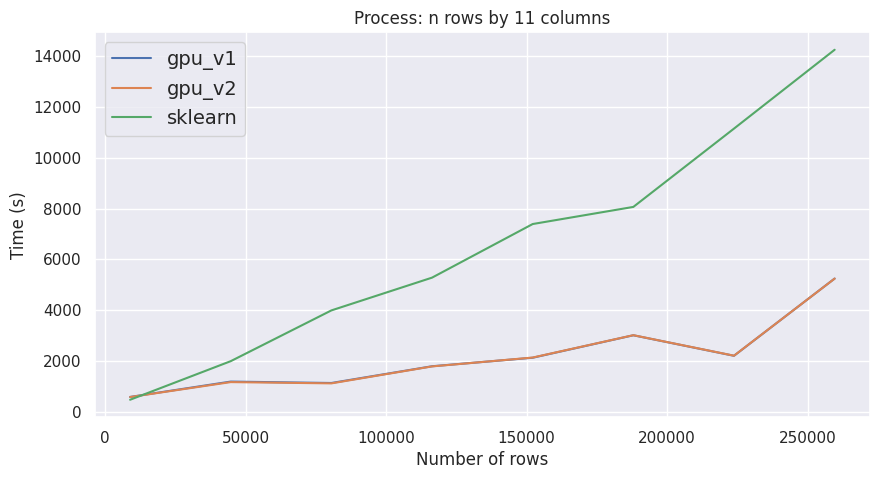

In [ ]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'gpu_v1', 'gpu_v2', 'sklearn'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)
ax = df_viz.plot()
ax.set_title('Process: n rows by 11 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (s)')
plt.legend(prop={'size': 14})

In [ ]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,gpu_v1,gpu_v2,sklearn
num_rows,,,
8950,588.509434,584.594347,478.061426
44750,1192.785014,1172.105051,1995.741905
80550,1137.288267,1122.301416,3991.988918
116350,1795.344707,1789.071810,5280.844115
152150,2130.600432,2137.712125,7389.035562
187950,3014.183226,3017.183693,8062.408179
223750,2206.986065,2211.172216,11142.520068
259550,5244.648927,5242.485067,14243.723741


**Nhận xét**
- Từ biểu đồ so sánh khi thực hiện tăng kích thước của dataset, ta có thể thấy được sự vượt trội của việc sử dụng cuda khi so sánh với Sklearn.
- Kmeans trên CPU không được đem ra so sánh ở đây vì ta đã có thể khẳng định rằng tốc độ của Kmeans tuần tự trên CPU sẽ chậm hơn rất nhiều khi so với 3 phương pháp còn lại. Điều này sẽ làm cho việc trực quan hóa trở nên khó khăn hơn
- Kết quả của Kmeans có sử dụng share memory và không sử dụng không có quá nhiều sự khác biệt rõ ràng. Ở một số thời điểm, việc không sử dụng share memory còn nhanh hơn một chút

## Conclusion
- Kết quả thu được cho thấy việc ứng dụng song song hóa bằng cuda vào bài toán đã giảm thời gian thực thi đi rất nhiều đối với cả quá trình preprocess và Kmeans
- Đồng thời, từ những phương pháp đánh giá kể trên, trong trường hợp dataset có tăng kích thước thì sử dụng cuda vẫn là lựa chọn tốt cho bài toán.
- Điểm sáng nhất ở đây là kết quả đã phần nào vượt qua các thư viện có sẵn trên Python, cụ thể là Sklearn.

## References
- https://iopscience.iop.org/article/10.1088/1757-899X/790/1/012036/pdf
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://www.kaggle.com/code/des137/customer-segmentation-credit-cards
- http://users.eecs.northwestern.edu/~wkliao/Kmeans/
- https://www.mdpi.com/2079-9292/7/11/283

## Lời kết
Tuy không phải là đề tài quá thách thức cũng như còn rất nhiều thiếu sót, tuy nhiên nhóm đã làm tất cả những thứ trong khả năng để có thể có kết quả là file notebook này. Đây là môn học cuối của 3 thành viên, do vậy nhóm rất cảm ơn quý thầy đã đồng hành cùng nhóm trong môn học này. Những kiến thức học được từ đồ án là rất đáng giá và có ích với chúng em. Hy vọng đây sẽ là nền tảng kiến thức để các thành viên có thể sử dụng và đi xa hơn trên con đường khoa học máy tính.